   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Records count: 768
Filtered records count: 763
Parameters: coeff = 0.1939, power = 0.7325

Distribution comparison results:
Max difference = 0.5264
Critical threshold = 0.1271
Model validation failed


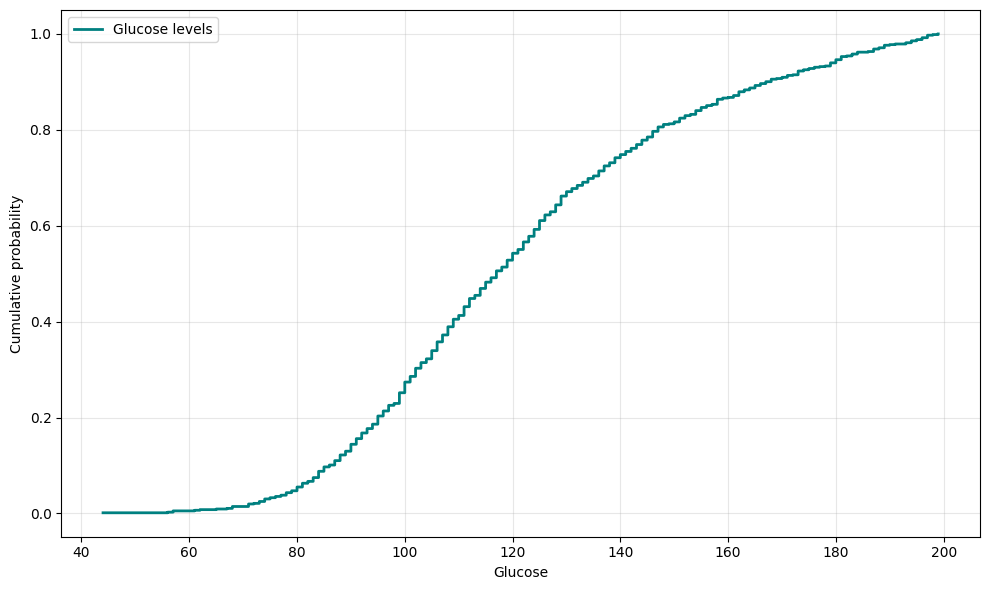

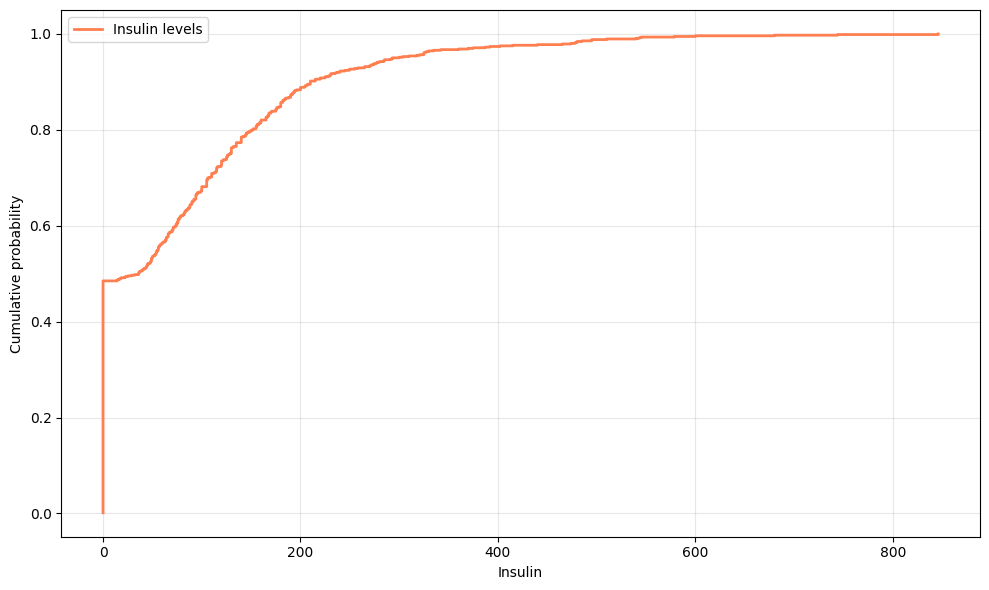

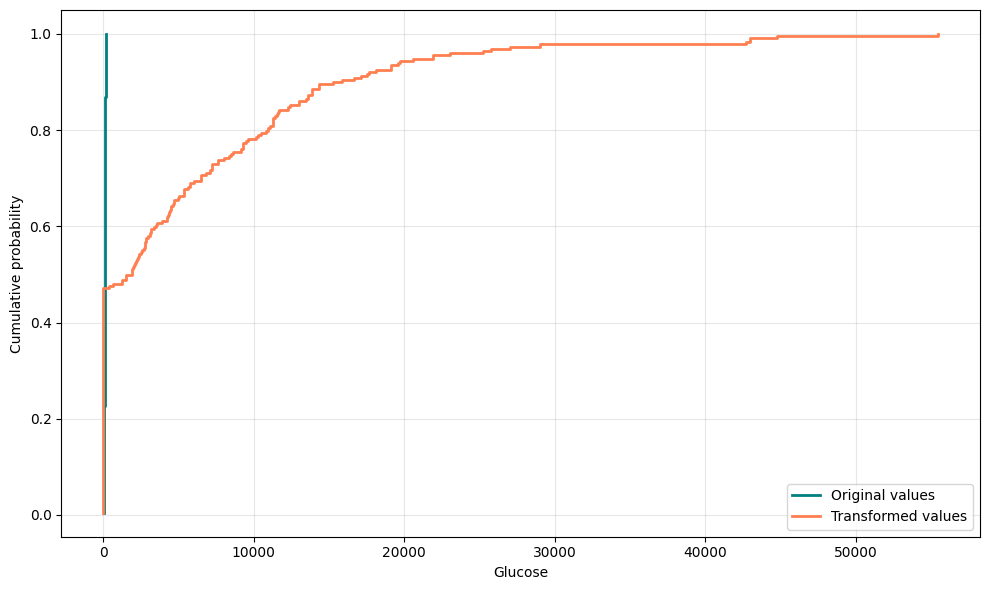

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

df = pd.read_csv('diabetes.csv')

print(df.head())
df = df[['Glucose', 'Insulin']].dropna()
print(f"Records count: {len(df)}")
df = df[df['Glucose'] > 0]

shift_value = 0.3
df['Glucose_adj'] = df['Glucose']
df['Insulin_adj'] = df['Insulin'] + shift_value

print(f"Filtered records count: {len(df)}")

train_set, test_set = train_test_split(df, test_size=0.3, random_state=42)

def fit_power_model(x_values, y_values):
    log_x = np.log(x_values)
    log_y = np.log(y_values)
    slope = np.cov(log_x, log_y)[0,1] / np.var(log_x)
    intercept = np.exp(np.mean(log_y) - slope*np.mean(log_x))
    return intercept, slope

coeff, power = fit_power_model(train_set['Glucose_adj'], train_set['Insulin_adj'])
print(f"Parameters: coeff = {coeff:.4f}, power = {power:.4f}")

def compare_distributions(sample_A, sample_B):
    sorted_A = np.sort(sample_A)
    sorted_B = np.sort(sample_B)

    def calculate_ecdf(data):
        x = np.sort(data)
        y = np.arange(1, len(x) + 1) / len(x)
        return x, y

    x_A, y_A = calculate_ecdf(sorted_A)
    x_B, y_B = calculate_ecdf(sorted_B)

    combined_x = np.sort(np.concatenate([x_A, x_B]))
    y_A_interp = np.interp(combined_x, x_A, y_A)
    y_B_interp = np.interp(combined_x, x_B, y_B)

    max_diff = np.max(np.abs(y_A_interp - y_B_interp))

    n_A, n_B = len(sample_A), len(sample_B)
    threshold = 1.36 * math.sqrt((n_A + n_B) / (n_A * n_B))

    return max_diff, threshold

transformed_values = (test_set['Insulin_adj'] / coeff) ** (1 / power)

diff_value, threshold_value = compare_distributions(test_set['Glucose_adj'], transformed_values)

def plot_distribution(data, label_name, line_color):
    sorted_data = np.sort(data)
    ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    plt.step(sorted_data, ecdf, where='post', label=label_name, color=line_color, linewidth=2)

print("\nDistribution comparison results:")
print(f"Max difference = {diff_value:.4f}")
print(f"Critical threshold = {threshold_value:.4f}")
if diff_value < threshold_value:
    print("Model validation passed")
else:
    print("Model validation failed")

plt.figure(figsize=(10, 6))
plot_distribution(df['Glucose'], "Glucose levels", "teal")
plt.xlabel('Glucose')
plt.ylabel('Cumulative probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plot_distribution(df['Insulin'], "Insulin levels", "coral")
plt.xlabel('Insulin')
plt.ylabel('Cumulative probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plot_distribution(test_set['Glucose_adj'], "Original values", "teal")
plot_distribution(transformed_values, "Transformed values", "coral")
plt.xlabel('Glucose')
plt.ylabel('Cumulative probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()